In [1]:
import os
import sys
import torch
from torchvision import datasets, transforms
from torchvision.transforms import transforms
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt

# Add the path to the src module
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from src import get_data
from src.models import *
from src.utils import cov

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
def create_binary_patterns(N, d, c, seed=None):
    """
    Create N d-dimensional binary patterns and a corrupted version.

    Args:
        N (int): Number of patterns.
        d (int): Dimensionality of each pattern.
        c (int): Number of dimensions to corrupt.
        seed (int, optional): Seed for random number generator.

    Returns:
        tuple: A tuple containing two torch.Tensors:
            - Original binary patterns of shape (N, d)
            - Corrupted binary patterns of shape (N, d) with last c dimensions set to 0
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    original_patterns = torch.randint(0, 2, (N, d)).float() * 2 - 1  # Convert to {-1, 1}
    corrupted_patterns = original_patterns.clone()
    corrupted_patterns[:, -c:] = 0
    
    return original_patterns, corrupted_patterns

In [54]:
dim = 5
N = 2
c = 2
seed = 42

In [55]:
patterns, corrupted_patterns = create_binary_patterns(N, dim, c, seed)
patterns = patterns.to(device)
corrupted_patterns = corrupted_patterns.to(device)
print(patterns)
print(corrupted_patterns)

tensor([[-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1.,  1.]], device='cuda:0')
tensor([[-1.,  1., -1.,  0.,  0.],
        [ 1., -1., -1.,  0.,  0.]], device='cuda:0')


In [56]:
hn = HopfieldNetwork(5).to(device)
hn.learning(patterns)
retrieved_patterns = hn.inference(corrupted_patterns, steps=100)
print(retrieved_patterns)

tensor([[-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1.,  1.]], device='cuda:0', grad_fn=<SignBackward0>)


In [57]:
def pcn_train_inference(
    pcn,
    learning_lr,
    inference_lr,
    learning_iters,
    inference_iters,
):
    optimizer = torch.optim.SGD(pcn.parameters(), lr=learning_lr)
    learning_mses = []
    for i in range(learning_iters):
        optimizer.zero_grad()
        pcn.learning(patterns)
        optimizer.step()
        mse = pcn.train_mse.cpu().detach().numpy()
        learning_mses.append(mse)

    inference_mses = []
    recon = corrupted_patterns.clone()
    for j in range(inference_iters):
        mse = torch.mean((recon - patterns)**2).cpu().detach().numpy()
        delta = pcn.inference(recon)
        recon = torch.sign(recon + inference_lr * delta)
        inference_mses.append(mse)

    return learning_mses, inference_mses, recon

In [58]:
pcn_imp = RecPCN(dim=dim, dendrite=False).to(device)
learning_mses_imp, inference_mses_imp, recon_imp = pcn_train_inference(
    pcn_imp, 2e-3, 1e-1, 500, 10
)

In [59]:
pcn_exp = ExplicitPCN(dim=dim).to(device)
learning_mses_exp, inference_mses_exp, recon_exp = pcn_train_inference(
    pcn_exp, 1e-3, 1e-2, 800, 10
)

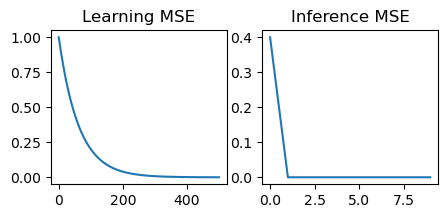

In [60]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].plot(learning_mses_imp)
ax[0].set_title("Learning MSE")
ax[1].plot(inference_mses_imp)
ax[1].set_title("Inference MSE")
plt.show()


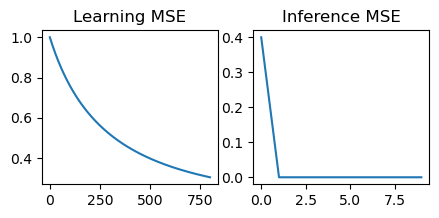

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
ax[0].plot(learning_mses_exp)
ax[0].set_title("Learning MSE")
ax[1].plot(inference_mses_exp)
ax[1].set_title("Inference MSE")
plt.show()

In [62]:
recon_imp

tensor([[-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1.,  1.]], device='cuda:0', grad_fn=<SignBackward0>)

In [63]:
recon_exp

tensor([[-1.,  1., -1., -1., -1.],
        [ 1., -1., -1., -1.,  1.]], device='cuda:0', grad_fn=<SignBackward0>)

In [64]:
corrupted_patterns

tensor([[-1.,  1., -1.,  0.,  0.],
        [ 1., -1., -1.,  0.,  0.]], device='cuda:0')

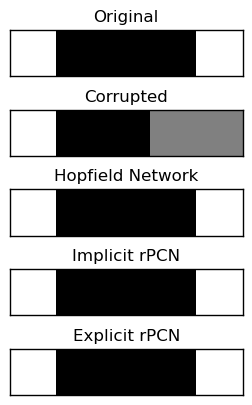

In [65]:
# visualize the original, corrupted and reconstructed patterns by 3 models
fig, ax = plt.subplots(5, 1, figsize=(3, 5))
ax[0].imshow(patterns[1].cpu().numpy().reshape(1, -1), cmap="gray")
ax[0].set_title("Original")
ax[1].imshow(corrupted_patterns[1].cpu().numpy().reshape(1, -1), cmap="gray")
ax[1].set_title("Corrupted")
ax[2].imshow(retrieved_patterns[1].detach().cpu().numpy().reshape(1, -1), cmap="gray")
ax[2].set_title("Hopfield Network")
ax[3].imshow(recon_imp[1].detach().cpu().numpy().reshape(1, -1), cmap="gray")
ax[3].set_title("Implicit rPCN")
ax[4].imshow(recon_exp[1].detach().cpu().numpy().reshape(1, -1), cmap="gray")
ax[4].set_title("Explicit rPCN")
for i in range(5):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
# add border to each ax
    for spine in ax[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
plt.savefig("recon_binary.svg", bbox_inches="tight")
plt.show()

In [66]:
# repeat the experiment with different number of corrupted dimensions (from 1-4) and different seeds (42, 48, 56)
dim = 5
N = 2
seeds = [42, 48, 56, 122, 89]
corrupted_dims = [1, 2, 3, 4]
hn_mses = np.zeros((len(seeds), len(corrupted_dims)))
pcn_imp_mses = np.zeros((len(seeds), len(corrupted_dims)))
pcn_exp_mses = np.zeros((len(seeds), len(corrupted_dims)))

for seed in seeds:
    for c in corrupted_dims:
        patterns, corrupted_patterns = create_binary_patterns(N, dim, c, seed)
        patterns = patterns.to(device)
        corrupted_patterns = corrupted_patterns.to(device)
        hn = HopfieldNetwork(dim).to(device)
        hn.learning(patterns)
        hn_recon = hn.inference(corrupted_patterns, steps=100)
        hn_mse = torch.mean((hn_recon - patterns)**2).cpu().detach().numpy()
        hn_mses[seeds.index(seed), corrupted_dims.index(c)] = hn_mse
        pcn_imp = RecPCN(dim=dim, dendrite=False).to(device)
        learning_mses_imp, inference_mses_imp, recon_imp = pcn_train_inference(
            pcn_imp, 2e-3, 1e-1, 500, 10
        )
        pcn_imp_mse = inference_mses_imp[-1]
        pcn_imp_mses[seeds.index(seed), corrupted_dims.index(c)] = pcn_imp_mse
        pcn_exp = ExplicitPCN(dim=dim).to(device)
        learning_mses_exp, inference_mses_exp, recon_exp = pcn_train_inference(
            pcn_exp, 1e-3, 1e-2, 800, 10
        )
        pcn_exp_mse = inference_mses_exp[-1]
        pcn_exp_mses[seeds.index(seed), corrupted_dims.index(c)] = pcn_exp_mse

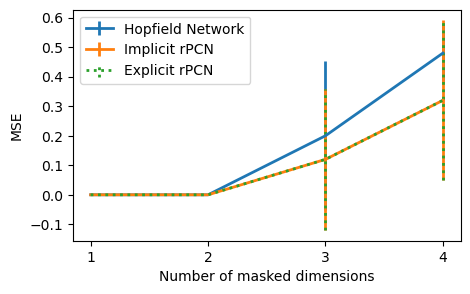

In [68]:
# calculate the mean and std of mse for each model over the seeds
plt.style.use("default")
hn_mses_mean = np.mean(hn_mses, axis=0)
hn_mses_std = np.std(hn_mses, axis=0)
pcn_imp_mses_mean = np.mean(pcn_imp_mses, axis=0)
pcn_imp_mses_std = np.std(pcn_imp_mses, axis=0)
pcn_exp_mses_mean = np.mean(pcn_exp_mses, axis=0)
pcn_exp_mses_std = np.std(pcn_exp_mses, axis=0)

# plot the mse of each model over the number of corrupted dimensions
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.errorbar(corrupted_dims, hn_mses_mean, yerr=hn_mses_std, label="Hopfield Network",lw=2)
ax.errorbar(corrupted_dims, pcn_imp_mses_mean, yerr=pcn_imp_mses_std, label="Implicit rPCN",lw=2)
eb = ax.errorbar(corrupted_dims, pcn_exp_mses_mean, yerr=pcn_exp_mses_std, label="Explicit rPCN", ls=":",lw=2)
eb[-1][0].set_linestyle(':')
ax.set_xlabel("Number of masked dimensions")
ax.set_ylabel("MSE")
ax.set_xticks(corrupted_dims)
ax.legend()
plt.savefig("mse_binary.svg", bbox_inches="tight")
plt.show()